In [434]:
import pandas as pd
import glob
import datetime
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np
from sklearn.metrics import root_mean_squared_error
from xgboost import plot_importance



IMPORTING/ CLEANING DATA

In [450]:
#import 2015 to 2025 MW demand data, ignore title row from each and concatenate all csv files together by row, adding new title row
path = "Ontario_MW_Project\IESO_MW_Data"
all_files = glob.glob(path + "/*.csv")
dfs = []
for files in all_files:
    df_2 = pd.read_csv(files, skiprows=1, header=None)
    df_2.columns = ["Datetime", "Hour", "Market Demand", "Ontario Demand"]
    dfs.append(df_2)
df = pd.concat(dfs, ignore_index=True, axis=0)

<>:2: SyntaxWarning: invalid escape sequence '\I'
<>:2: SyntaxWarning: invalid escape sequence '\I'
C:\Users\ryley\AppData\Local\Temp\ipykernel_32980\2173564089.py:2: SyntaxWarning: invalid escape sequence '\I'
  path = "Ontario_MW_Project\IESO_MW_Data"
C:\Users\ryley\AppData\Local\Temp\ipykernel_32980\2173564089.py:2: SyntaxWarning: invalid escape sequence '\I'
  path = "Ontario_MW_Project\IESO_MW_Data"


ValueError: No objects to concatenate

In [ ]:

#Set hour to numeric, replace hour 24 with hour 0 for easier datetime conversion
df['Hour']=pd.to_numeric(df['Hour'], errors='coerce')
df['Hour'] = df['Hour'].replace(24,0)


#Convert Date column to datetime format, combine with hour column, drop hour column
df['Datetime'] = pd.to_datetime(df["Datetime"], format="%Y-%m-%d")
df["Datetime"] = df["Datetime"] + pd.to_timedelta(df['Hour'], unit='h')
df = df.set_index('Datetime')
df.drop(columns=['Hour'], inplace=True)
df.drop(columns=['Market Demand'], inplace=True)
df

,Ontario Demand
Datetime,
2015-01-01 01:00:00,14960
2015-01-01 02:00:00,14476
2015-01-01 03:00:00,13979
2015-01-01 04:00:00,13670
2015-01-01 05:00:00,13567
...,...
2025-08-04 20:00:00,19639
2025-08-04 21:00:00,19156
2025-08-04 22:00:00,18074


In [437]:
#Separate train and test sets (trial: 70/30 split)

#Determine number of unique hours in Datetime index, calculate 70% of that number
train_hours = int(df.index.nunique() * 0.7)

#Split train and test sets using index values for slicing
train = df[df.index <= df.index[train_hours]].copy()
test = df[df.index > df.index[train_hours]].copy()
train


,Ontario Demand
Datetime,
2015-01-01 01:00:00,14960
2015-01-01 02:00:00,14476
2015-01-01 03:00:00,13979
2015-01-01 04:00:00,13670
2015-01-01 05:00:00,13567
...,...
2022-06-01 03:00:00,13803
2022-06-01 04:00:00,13941
2022-06-01 05:00:00,14203


VISUALIZATION

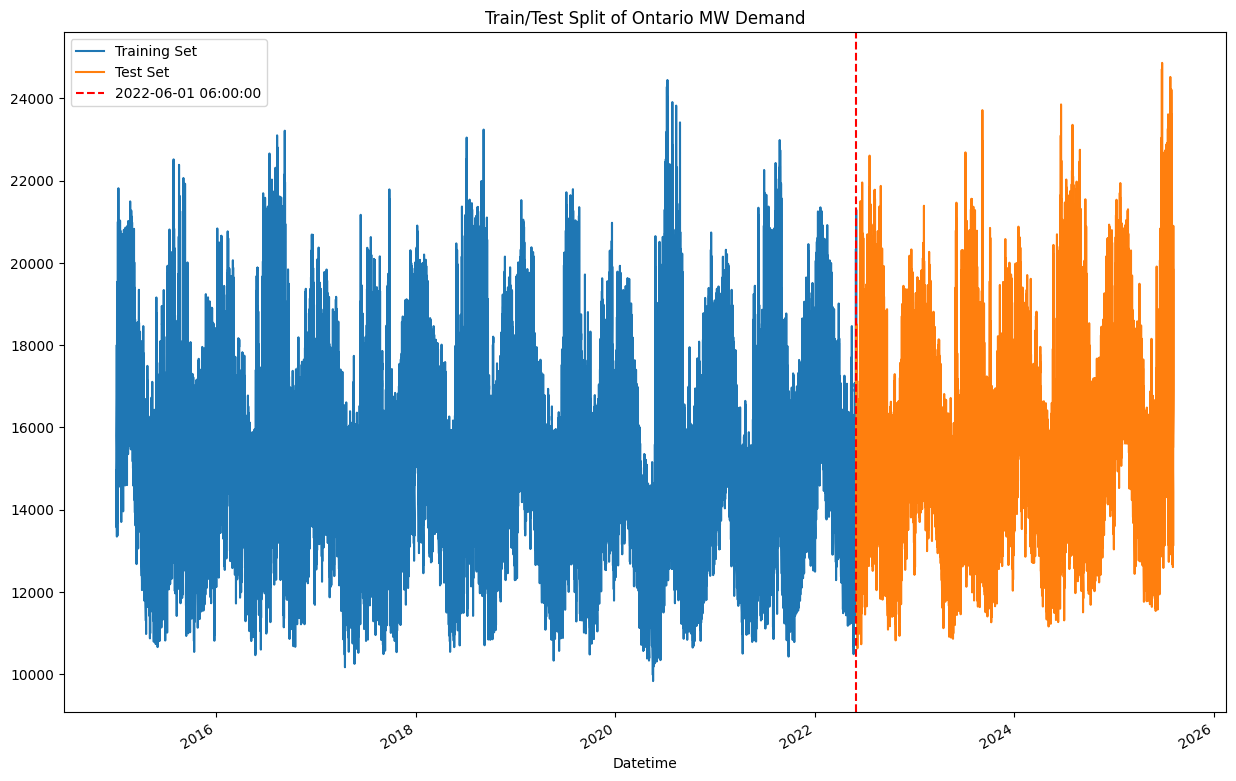

In [438]:
#Plotting train and test sets visualization 
fig, ax = plt.subplots(figsize = (15,10))
train.plot(ax=ax, label='Training Set', title='Train/Test Split of Ontario MW Demand')
test.plot(ax=ax, label='Test Set')
ax.axvline(df.index[train_hours], label = df.index[train_hours],color='red', ls='--')
ax.legend(['Training Set', 'Test Set', df.index[train_hours]])
plt.show()

FEATURE CREATION

In [439]:
#Import Canadian holidays dataset (pulled from https://github.com/uWaterloo/Datasets/blob/master/Holidays/holidays.csv)
holidays = pd.read_csv(r"C:\Users\ryley\Documents\BTCforecasting\holidays.csv")
holidays['date'] = pd.to_datetime(holidays["date"], format="%Y-%m-%d")
holidays = holidays.set_index('date')
holidays

,holiday
date,
2012-01-02,New Year's Day
2012-02-20,Family Day
2012-04-06,Good Friday
2012-05-21,Victoria Day
2012-07-02,Canada Day
...,...
2026-02-16,Family Day
2026-04-03,Good Friday
2026-05-18,Victoria Day


In [440]:
#Train feature creation by breaking down hourly MW datetime index into time components
train['Year'] = train.index.year
train['Month'] = train.index.month
train['DayOfMonth'] = train.index.day
train['DayOfYear'] = train.index.dayofyear
train['Hour'] = train.index.hour
train['DayOfWeek'] = train.index.dayofweek
train['WeekOfYear'] = train.index.isocalendar().week
train['Quarter'] = train.index.quarter

#Create holiday feature by setting holiday dates to true and non holidays to false 
train['Holiday'] = train.index.date
train['Holiday'] = train['Holiday'].isin(holidays.index.date).astype(bool)

#Test feature creation by breaking down hourly MW datetime index into time components
test['Year'] = test.index.year
test['Month'] = test.index.month
test['DayOfMonth'] = test.index.day
test['DayOfYear'] = test.index.dayofyear
test['Hour'] = test.index.hour
test['DayOfWeek'] = test.index.dayofweek
test['WeekOfYear'] = test.index.isocalendar().week
test['Quarter'] = test.index.quarter

#Create holiday feature by setting holiday dates to true and non holidays to false 
test['Holiday'] = test.index.date
test['Holiday'] = test['Holiday'].isin(holidays.index.date).astype(bool)

test.head(5000)

,Ontario Demand,Year,Month,DayOfMonth,DayOfYear,Hour,DayOfWeek,WeekOfYear,Quarter,Holiday
Datetime,,,,,,,,,,
2022-06-01 07:00:00,16729,2022,6,1,152,7,2,22,2,False
2022-06-01 08:00:00,18058,2022,6,1,152,8,2,22,2,False
2022-06-01 09:00:00,18236,2022,6,1,152,9,2,22,2,False
2022-06-01 10:00:00,17721,2022,6,1,152,10,2,22,2,False
2022-06-01 11:00:00,17490,2022,6,1,152,11,2,22,2,False
...,...,...,...,...,...,...,...,...,...,...
2022-12-26 11:00:00,17290,2022,12,26,360,11,0,52,4,True
2022-12-26 12:00:00,17325,2022,12,26,360,12,0,52,4,True
2022-12-26 13:00:00,17263,2022,12,26,360,13,0,52,4,True


TRAINING

In [441]:
#Training XGBoost model

#Assigning independent and dependent variables to dataframes
train_features = train[['Year', 'Month', 'DayOfMonth', 'DayOfYear', 'Hour', 'DayOfWeek', 'WeekOfYear', 'Quarter', 'Holiday']]
train_target = train['Ontario Demand']

test_features = test[['Year', 'Month', 'DayOfMonth', 'DayOfYear', 'Hour', 'DayOfWeek', 'WeekOfYear', 'Quarter', 'Holiday']]
test_target = test['Ontario Demand']

In [442]:
#establishing model parameters and training model
model = xgb.XGBRegressor(n_estimators=5000, early_stopping_rounds=50, learning_rate=0.01)
model.fit(train_features, train_target, eval_set=[(train_features, train_target), (test_features, test_target)], verbose=100)

[0]	validation_0-rmse:2322.52340	validation_1-rmse:2386.15422


[100]	validation_0-rmse:1444.33681	validation_1-rmse:1580.30533
[200]	validation_0-rmse:1177.09996	validation_1-rmse:1357.38118
[300]	validation_0-rmse:1067.42035	validation_1-rmse:1284.67290
[400]	validation_0-rmse:988.67290	validation_1-rmse:1203.01964
[500]	validation_0-rmse:932.03506	validation_1-rmse:1205.45430
[505]	validation_0-rmse:929.87087	validation_1-rmse:1208.31994


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


In [443]:
#Checking baseline RMSE
prediction_mean = np.mean(train_target)
baseline_rmse = root_mean_squared_error(train_target, np.full_like(train_target, prediction_mean))
print("Baseline RMSE (mean prediction): " + str(baseline_rmse))

Baseline RMSE (mean prediction): 2338.316064584209


TESTING MODEL

In [ ]:
#predicting MW demand for test set
test['Predicted Demand'] = model.predict(test_features)
#Calculating RMSE for test set predictions
test_RMSE = root_mean_squared_error(test_target, test['Predicted Demand'])
print(test_RMSE)
test

1189.943603515625


,Ontario Demand,Year,Month,DayOfMonth,DayOfYear,Hour,DayOfWeek,WeekOfYear,Quarter,Holiday,Predicted Demand,RMSE
Datetime,,,,,,,,,,,,
2022-06-01 07:00:00,16729,2022,6,1,152,7,2,22,2,False,15031.375977,1189.943604
2022-06-01 08:00:00,18058,2022,6,1,152,8,2,22,2,False,15805.694336,1189.943604
2022-06-01 09:00:00,18236,2022,6,1,152,9,2,22,2,False,16275.124023,1189.943604
2022-06-01 10:00:00,17721,2022,6,1,152,10,2,22,2,False,16401.339844,1189.943604
2022-06-01 11:00:00,17490,2022,6,1,152,11,2,22,2,False,16316.261719,1189.943604
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-04 20:00:00,19639,2025,8,4,216,20,0,32,3,True,18809.763672,1189.943604
2025-08-04 21:00:00,19156,2025,8,4,216,21,0,32,3,True,18638.496094,1189.943604
2025-08-04 22:00:00,18074,2025,8,4,216,22,0,32,3,True,17493.890625,1189.943604


FEATURE IMPORTANCE

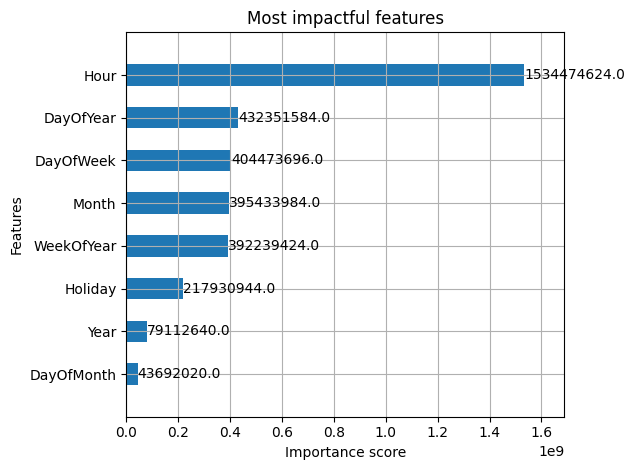

In [ ]:
#Examining feature importance
plot_importance(model, importance_type='gain', max_num_features=10, height=0.5)
plt.title("Most impactful features")
plt.tight_layout()
plt.show()